In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# Homework 8: Fairness in Housing Appraisal and Gradient Descent

## Due Date:  Thursday Apr 8, 11:59 PM

## This Assignment

This assignment consists of 2 parts. In these parts, we will:

1. Examine some of the HCE concerns from the housing dataset in the last assignment. 
1. Implement gradient descent, and show how it can be used to minimize differentiable functions, even including loss functions for non-linear models.


Note that the first part of this assignment will use bold notation to represent vectors, i.e. $\mathbf{x}$.

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the assignment, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

**Collaborators:** ...

## Point Distribution
| Question | Points | 
|----------|--------|
| 1 | 1 |
| 2 | 1 |
| 3 | 1 |
| 4 | 1 |
| 5 | 1 |
| 6 | 1 |
| 7 | 1 |
| 8 | 1 |
| 9a | 2 |
| 9b | 2 |
| 10a | 2 |
| 10b | 2 |
| 10c | 2 |
| 10d | 2 |
| Total | 20 | 

## Part 1: Human Contexts and Ethics

Recall that in Homework 7 we used data from the Cook County Assessor's Office to predict housing prices based on various features. From that assignment:

>  The dataset you’ll be working with comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.
<br><br>
The CCAO dataset consists of over 500 thousand records describing houses sold in Cook County in recent years (new records are still coming in every week!). The data set we will be working with has 61 features in total. An explanation of each variable can be found in the included `codebook.txt` file. Some of the columns have been filtered out to ensure this assignment doesn't become overly long when dealing with data cleaning and formatting.

For reference, you can find the codebook [here](https://raw.githubusercontent.com/DS-100/sp21/main/hw/hw7/codebook.txt).

The reason that we have access to such a well-documented data set and model is largely due to an investigation in 2017 that found the property taxes were levied in a manner that systematically benefited the wealthy. Use the context behind this data as described in [Lecture 17](https://ds100.org/sp21/lecture/lec17/) to answer the following questions.

<!-- BEGIN QUESTION -->

### Question 1

In the context of estimating the value of houses, what does error mean for an individual homeowner? How does it affect them in terms of property taxes?

<!--
BEGIN QUESTION
name: q1
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2

How do the CCAO’s transparency initiatives aim to redistribute power between the tax lawyer industry, the CCAO, and the constituents of Cook County?

**Hint**: You may find the following [official post from CCAO](https://datacatalog.cookcountyil.gov/stories/s/p2kt-hk36) helpful.

<!--
BEGIN QUESTION
name: q2
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3

Take a look at the Residential Automated Valuation Model files under the Models subgroup in the CCAO’s [GitLab](https://gitlab.com/ccao-data-science---modeling). Without directly looking at any code, do you feel that the documentation sufficiently explains how the residential valuation model works? Which part(s) of the documentation might be difficult for nontechnical audiences to understand?

<!--
BEGIN QUESTION
name: q3
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 4

How could the CCAO improve its implementation of transparency? What aspects of it are inaccessible and to whom? Consider the concepts of expertise and power.

<!--
BEGIN QUESTION
name: q4
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 5

How does the CCAO's open data initiative support it in maintaining people’s trust in its housing assessments?

<!--
BEGIN QUESTION
name: q5
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



## Part 2: Gradient Descent

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import seaborn as sns
import sklearn
import sklearn.datasets
import sklearn.linear_model

np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")

# Set some parameters
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16
np.set_printoptions(4)

# We will use plot_3d helper function to help us visualize gradients
from hw8_utils import plot_3d

%matplotlib inline

### Load Data
Load the data.csv file into a pandas dataframe.
Note that we are reading the data directly from the URL address.

In [3]:
# Run this cell to load our sample data
part_1_data = pd.read_csv("https://github.com/DS-100/su20/raw/gh-pages/resources/assets/datasets/hw7_data.csv", index_col=0)
part_1_data.head()

,x,y
0,-5.000000,-7.672309
1,-4.966555,-7.779735
2,-4.933110,-7.995938
3,-4.899666,-8.197059
4,-4.866221,-8.183883


### A Simple Model

Let's start by examining our data and creating a simple model that can represent this data.

First, run the cell below to visualize our data.

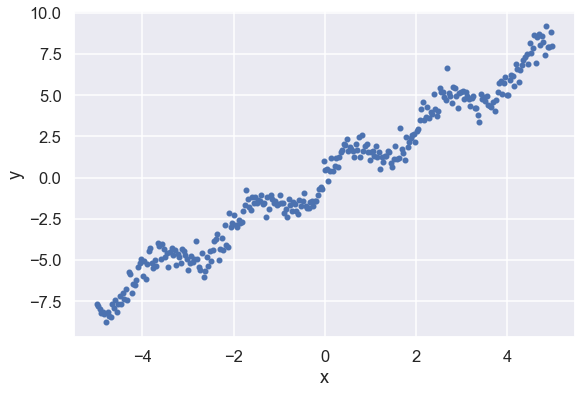

In [4]:
def scatter(x, y):
    """
    Generate a scatter plot using x and y

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, marker='.')
    plt.xlabel('x')
    plt.ylabel('y')
    
x = part_1_data['x']
y = part_1_data['y']
scatter(x,y)

The data looks roughly linear, with some extra sinusoidal noise. For now, let's assume that the data follows some underlying linear model. We define the underlying linear model that predicts the value $y$ using the value $x$ as: $f_{\theta^*}(x) = \theta^* \cdot x$

Since we cannot find the value of the population parameter $\theta^*$ exactly, we will assume that our dataset approximates our population and use our dataset to estimate $\theta^*$. We denote an estimate with $\theta$ and the fitted estimated chosen based on the data as $\hat{\theta}$. Our parameterized model is:

$$\Large
f_{\theta}(x) = \theta \cdot x
$$

Based on this equation, we will define the linear model function `linear_model` below to estimate $\textbf{y}$ (the $y$-values) given $\textbf{x}$ (the $x$-values) and $\theta$.

In [5]:
def linear_model(x, theta):
    """
    Returns the estimate of y given x and theta

    Keyword arguments:
    x -- the vector of values x
    theta -- the scalar theta
    """
    return theta * x

In class, we learned that the squared loss function is smooth and continuous. Let's use squared loss to evaluate our estimate $\theta$, which we will use later to identify an optimal $\theta$, denoted $\hat{\theta}$. Given observations $y$ and their corresponding predictions $\hat{y}$, we can compute the average loss:

In [6]:
def average_squared_loss(y, y_hat):
    """
    Returns the averge squared loss for observations y and predictions y_hat.

    Keyword arguments:
    y -- the vector of true values y
    y_hat -- the vector of predicted values y_hat
    """
    return np.mean((y - y_hat) ** 2)

Finally, we will visualize the average squared loss as a function of $\theta$, where several different values of $\theta$ are given.

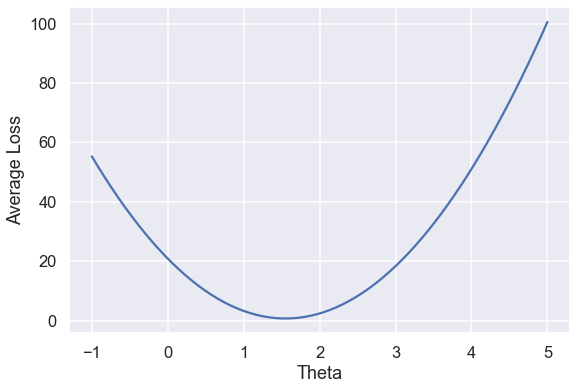

In [7]:
def visualize(x, y, thetas):
    """
    Plots the average l2 loss for given x, y as a function of theta.
    Use the functions you wrote for linear_model and l2_loss.

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    thetas -- an array containing different estimates of the scalar theta
    """ 
    avg_loss = np.array([average_squared_loss(linear_model(x, theta), y) for theta in thetas])
    plt.figure(figsize=(8,6))
    plt.plot(thetas, avg_loss)
    plt.xlabel("Theta")
    plt.ylabel("Average Loss")
    
thetas = np.linspace(-1, 5, 70)
visualize(x, y, thetas)

You should notice that $\hat{\theta}$ is approximately 1.5. 

### Fitting our Simple Model

Now that we have defined a simple linear model and loss function, let's begin working on fitting our model to the data.

#### Question 6
Let's confirm our visual findings for the optimal $\hat{\theta}$.

Recall from homework 6 that the analytical solution for the optimal $\hat{\theta}$ for the average squared loss is: 

$$\hat{\theta} = \frac{\sum_{i=1}^n x_i y_i}{\sum_{i=1}^n x_i^2}$$

Now that we have the analytic solution for $\hat{\theta}$, implement the function `find_theta` that calculates the numerical value of $\hat{\theta}$ based on our data $\textbf{x}$, $\textbf{y}$.

<!--
BEGIN QUESTION
name: q6
points: 1
-->

In [21]:
def find_theta(x, y):
    """
    Find optimal theta given x and y

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    """
    thetas = np.linspace(-1, 5, 10000)
    avg_loss = np.array([average_squared_loss(linear_model(x, theta), y) for theta in thetas])
    return thetas[np.argmin(avg_loss)]

theta_hat_simple = find_theta(x, y)
print(f'theta_hat = {theta_hat_simple}')

theta_hat = 1.5502550255025502


In [22]:
grader.check("q6")

q6 results: All test cases passed!

Now, let's plot our risk function again using the `visualize` function. But this time, we will add a vertical line at the optimal value of theta (plot the line $\theta = \hat{\theta}$).

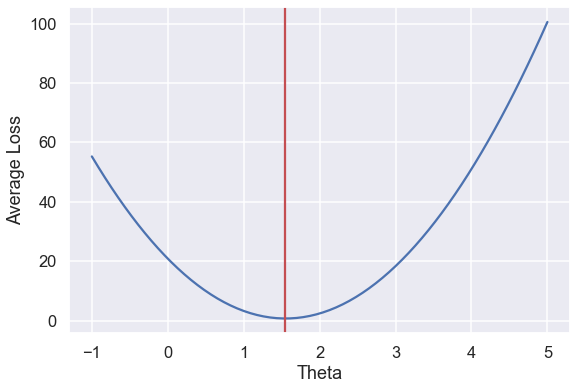

In [23]:
theta_opt = find_theta(x, y)
visualize(x, y, thetas)
plt.axvline(x=theta_opt, color='r');

We now have an optimal value for $\theta$ that minimizes the empirical risk. We can use the scatter plot of the data and add the line $f_{\hat{\theta}}(x) = \hat{\theta} \cdot \textbf{x}$ using the $\hat{\theta}$ computed above.

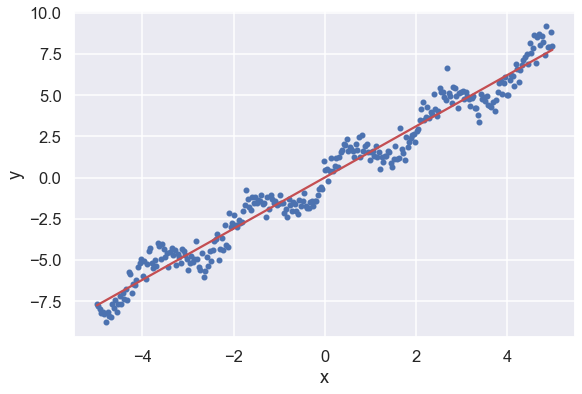

In [24]:
theta_opt_2 = find_theta(x, y)
scatter(x, y)
line_values = linear_model(x, theta_opt_2)
plt.plot(x, line_values, color='r');

Great! It looks like our estimator $f_{\hat{\theta}}(x)$ is able to estimate the average $y$ for each $x$ quite well using a single parameter $\theta$. 

The difference between the true $y$'s and the predictions is known as the residual, $\textbf{r}=\textbf{y}-\hat{\theta} \cdot \textbf{x}$. Below, we find the residual and plot the residuals corresponding to $x$ in a scatter plot. We also plot a horizontal line at $y=0$ to assist visualization.

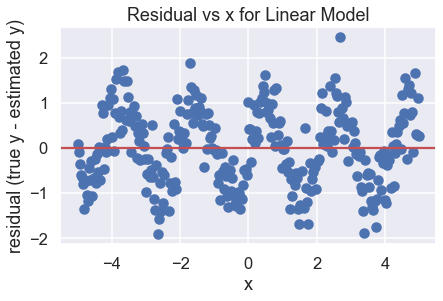

In [25]:
def visualize_residual(x, y):
    """
    Plot a scatter plot of the residuals, the remaining 
    values after removing the linear model from our data.

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    """
    ...
    theta_hat = find_theta(x, y)
    y_sin = y - linear_model(x, theta_hat)
    plt.scatter(x, y_sin)
    plt.xlabel('x')
    plt.ylabel('residual (true y - estimated y)')
    plt.title('Residual vs x for Linear Model')
    plt.axhline(y=0, color='r')

visualize_residual(x, y)

### Increasing Model Complexity

It looks like the residual is sinusoidal, meaning our original data follows a linear function and a sinusoidal function. Let's define a new model to address this discovery and find optimal parameters to best fit the data:

$$\Large
f_\boldsymbol\theta(x) = \theta_1x + sin(\theta_2x)
$$

Now, our model is parameterized by both $\theta_1$ and $\theta_2$, which we can represent in the vector, $\boldsymbol{\theta}$.

Note that a general sine function $a\sin(bx+c)$ has three parameters: amplitude scaling parameter $a$, frequency parameter $b$ and phase shifting parameter $c$. Looking at the residual plot above, it looks like the residual is zero at x = 0, and the residual swings between -1 and 1. Thus, it seems reasonable to effectively set the scaling and phase shifting parameter ($a$ and $c$ in this case) to 1 and 0 respectively. While we could try to fit $a$ and $c$, we're unlikely to get much benefit. When you're done with this assignment, you can try adding $a$ and $c$ to our model and fitting these parameters to see if you can get a better loss.

We define the `sin_model` function below that predicts $\textbf{y}$ (the $y$-values) using $\textbf{x}$ (the $x$-values) based on our new equation.

In [26]:
def sin_model(x, theta):
    """
    Predict the estimate of y given x, theta_1, theta_2

    Keyword arguments:
    x -- the vector of values x
    theta -- a vector of length 2, where theta[0] = theta_1 and theta[1] = theta_2
    """
    theta_1 = theta[0]
    theta_2 = theta[1]
    return theta_1 * x + np.sin(theta_2 * x)

<!-- BEGIN QUESTION -->

#### Question 7a

Recall the optimal value of $\theta$ minimizes our loss function. One way of solving for $\theta$ is by taking the derivative of our loss function with respect to $\theta$, like we did in HW 6.  

Write/derive the expressions for following values and write them with LaTeX in the space below.

* $R(\textbf{x}, \textbf{y}, \theta_1, \theta_2)$: our loss function, the empirical risk/mean squared error
* $\frac{\partial R }{\partial \theta_1}$: the partial derivative of $R$ with respect to $\theta_1$
* $\frac{\partial R }{\partial \theta_2}$: the partial derivative of $R$ with respect to $\theta_2$

Recall that $R(\textbf{x}, \textbf{y}, \theta_1, \theta_2) = \frac{1}{n} \sum_{i=1}^{n} (\textbf{y}_i - \hat{\textbf{y}}_i)^2$

<!--
BEGIN QUESTION
name: q7a
manual: True
points: 2
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

#### Question 7b
Now, implement the functions `sin_MSE`, `sin_MSE_dt1` and `sin_MSE_dt2`, which should compute $R$, $\frac{\partial R }{\partial \theta_1}$ and $\frac{\partial R }{\partial \theta_2}$ respectively. Use the expressions you wrote for $\frac{\partial R }{\partial \theta_1}$ and $\frac{\partial R }{\partial \theta_2}$ in the previous exercise. In the functions below, the parameter `theta` is a vector that looks like $( \theta_1, \theta_2 )$. We have completed `sin_MSE_gradient` for you.

Notes: 
* Keep in mind that we are still working with our original set of data, `part_1_data`.
* To keep your code a bit more concise, be aware that `np.mean` does the same thing as `np.sum` divided by the length of the numpy array.

<!--
BEGIN QUESTION
name: q7b
points: 2
-->

In [102]:
def sin_MSE(theta, x, y):
    """
    Compute the numerical value of the l2 loss of our sinusoidal model given theta

    Keyword arguments:
    theta -- the vector of values theta
    x     -- the vector of x values
    y     -- the vector of y values
    """
    yhat = theta[0] * x + np.sin(theta[1] * x)
    return np.mean((y - yhat) ** 2)

def sin_MSE_dt1(theta, x, y):
    """
    Compute the numerical value of the partial of l2 loss with respect to theta_1

    Keyword arguments:
    theta -- the vector of values theta
    x     -- the vector of x values
    y     -- the vector of y values
    """
    yhat = theta[0] * x + np.sin(theta[1] * x)
    return np.mean(-2 * (y - yhat) * x)
    
def sin_MSE_dt2(theta, x, y):
    """
    Compute the numerical value of the partial of l2 loss with respect to theta_2

    Keyword arguments:
    theta -- the vector of values theta
    x     -- the vector of x values
    y     -- the vector of y values
    """
    yhat = theta[0] * x + np.sin(theta[1] * x)
    return np.mean(-2 * (y - yhat) * x * np.cos(theta[1] * x))
    
# This function calls dt1 and dt2 and returns the gradient dt. It is already implemented for you.
def sin_MSE_gradient(theta, x, y):
    """
    Returns the gradient of l2 loss with respect to vector theta

    Keyword arguments:
    theta -- the vector of values theta
    x     -- the vector of x values
    y     -- the vector of y values
    """
    return np.array([sin_MSE_dt1(theta, x, y), sin_MSE_dt2(theta, x, y)])

In [103]:
grader.check("q7b")

q7b results: All test cases passed!

### Gradient Descent

In lecture, we saw that there are a number of ways to optimize a linear model:

1. Brute force guess and check
2. Analytically derive a closed form solution (like finding $\hat{\theta}$ by taking the derivative of the loss w.r.t. its parameters, as in HW 6)
3. Use a numerical method like gradient descent

You can try to solve for the optimal $\hat{\mathbf{\theta}}$ analytically using your answers from 2a, but we don't recommend it. Notably, observe that the model is not even linear, e.g. it contains $\theta_2$ inside a sine function.

To demonstrate how truly powerful techniques like gradient descent are, we'll use it in this assignment to optimize our nonlinear model.

Let's now implement gradient descent. 

Note that the function you're implementing here is somewhat different than the gradient descent function we created in lecture. The version in lecture was `gradient_descent(df, initial_guess, alpha, n)`, where `df` was the gradient of the function we are minimizing and `initial_guess` are the starting parameters for that function. Here our signature is a bit different (described below).

#### Question 8a

Implement the `grad_desc` function that performs gradient descent for a finite number of iterations. This function takes in a loss function, the gradient of the loss function, an initial value for $\theta$ (`theta`), and a dataframe containing the $\textbf{x}$ and $\textbf{y}$ values (`data`). `alpha` will be the learning rate (or step size, whichever term you prefer). In this part, we'll use a static learning rate (i.e. the same learning rate at every time step), just like in lecture.

At each time step, use the gradient and `alpha` to update your current `theta`. Also at each time step, be sure to save the current `theta` in `theta_history`, along with the average squared loss (computed with the current `theta`) in `loss_history`.

Recall that the gradient descent update function follows the form:

$$\Large
\boldsymbol\theta^{(t+1)} \leftarrow \boldsymbol\theta^{(t)} - \alpha \left ( \frac{1}{n} \sum_{i=1}^{n} \nabla_\boldsymbol\theta \mathbf{L}(\textbf{x}_i, \textbf{y}_i, \boldsymbol\theta^{(t)}) \right )
$$

where $\boldsymbol \theta$ is the parameter being optimized, $\alpha$ is the learning rate, $\nabla_\boldsymbol\theta \mathbf{L}$ is the gradient of the loss function with respect to $\boldsymbol \theta$, and $t$ is the optimization step counter (that is, $\boldsymbol \theta ^{(t)}$ is the value of $\boldsymbol \theta$ after $t$ steps of gradient descent).

After completing the function, the cell will output the trajectory from running gradient descent over time.

Hints:
- Write out the gradient update equation (1 step). What variables will you need for each gradient update? Of these variables, which ones do you already have, and which ones will you need to recompute at each time step?
- You may need a loop here to update `theta` several times. Take a look at `num_iter`.
- Be sure to include the initial theta and loss into the trajectory because the test checks for this.
- Don't forget that `sin_MSE` and `sin_MSE_gradient` require the $x$ and $y$ values to be supplied.

<!--
BEGIN QUESTION
name: q8a
points: 2
-->

In [118]:
def init_theta():
    """Creates an initial theta [0, 0] of shape (2,) as a starting point for gradient descent"""
    return np.zeros((2,))

def grad_desc(loss_f, gradient_loss_f, theta, data, num_iter=20, alpha=0.1):
    """
    Run gradient descent update for a finite number of iterations and static learning rate

    Keyword arguments:
    loss_f -- the loss function to be minimized (used for computing loss_history)
    gradient_loss_f -- the gradient of the loss function to be minimized
    theta -- the vector of values theta to use at first iteration
    data -- the data used in the model 
    num_iter -- the max number of iterations
    alpha -- the learning rate (also called the step size)
    
    Return:
    theta -- the optimal value of theta after num_iter of gradient descent
    theta_history -- the series of theta values over each iteration of gradient descent
    loss_history -- the series of loss values over each iteration of gradient descent
    """

    x = data['x']
    y = data['y']

    theta_history = [theta]
    loss_history = [np.mean((y - (theta[0] * x + np.sin(theta[1] * x))) ** 2)]

    while len(theta_history) <= num_iter:
        yhat0 = theta[0] * x + np.sin(theta[1] * x)
        dth0 = np.mean(-2 * (y - yhat0) * x)
    
        yhat1 = theta[0] * x + np.sin(theta[1] * x)
        dth1 = np.mean(-2 * (y - yhat1) * x * np.cos(theta[1] * x))

        gradient_loss_f = np.array([dth0, dth1])

        theta = theta - alpha * gradient_loss_f
        theta_history.append(theta)
        yhat = theta[0] * x + np.sin(theta[1] * x)
        loss_f = np.mean((y - yhat) ** 2)
        loss_history.append(loss_f)

    return theta, theta_history, loss_history

theta_start = init_theta()
theta_hat, thetas_used, losses_calculated = grad_desc(
    sin_MSE, sin_MSE_gradient, theta_start, part_1_data, num_iter=20, alpha=0.1
)
for b, l in zip(thetas_used, losses_calculated):
    print(f"theta: {b}, Loss: {l}")

theta: [0. 0.], Loss: 20.859191416422227
theta: [2.6011 2.6011], Loss: 9.285008173048677
theta: [0.9034 2.591 ], Loss: 4.680169273815355
theta: [2.0563 2.9631], Loss: 2.624251793632575
theta: [1.1589 2.8669], Loss: 1.4765157174727748
theta: [1.7939 3.0728], Loss: 0.9073271435862436
theta: [1.3216 3.0015], Loss: 0.5415316432911274
theta: [1.6495 3.0291], Loss: 0.3775841142469472
theta: [1.4233 2.9882], Loss: 0.2969750688130755
theta: [1.583  3.0103], Loss: 0.2590425421375734
theta: [1.471  2.9893], Loss: 0.2397343944329184
theta: [1.5504 3.0017], Loss: 0.23034782416254637
theta: [1.4944 2.9914], Loss: 0.2255775832667723
theta: [1.5342 2.998 ], Loss: 0.2232177219190406
theta: [1.506  2.9929], Loss: 0.22202363967204022
theta: [1.526  2.9963], Loss: 0.22142811500262397
theta: [1.5119 2.9938], Loss: 0.22112776381775154
theta: [1.5219 2.9955], Loss: 0.2209774137365456
theta: [1.5148 2.9942], Loss: 0.22090173185683037
theta: [1.5198 2.9951], Loss: 0.22086378105845866
theta: [1.5163 2.9945], L

In [119]:
grader.check("q8a")

q8a results: All test cases passed!

#### Question 8b
Now, let's try using a decaying learning rate. Implement `grad_desc_decay` below, which performs gradient descent with a learning rate that decreases slightly with each time step. You should be able to copy most of your work from the previous part, but you'll need to tweak how you update `theta` at each time step.

By decaying learning rate, we mean instead of just a number $\alpha$, the learning should be now $\frac{\alpha}{t+1}$ where $t$ is the number of the current iteration of gradient descent. (Why do we need to add a '+ 1' in the denominator?)

**Note:** Be sure to include the initial theta and loss into the trajectory because the test checks for this.

<!--
BEGIN QUESTION
name: q8b
points: 2
-->

In [120]:
def grad_desc_decay(loss_f, gradient_loss_f, theta, data, num_iter=20, alpha=0.1):
    """
    Run gradient descent update for a finite number of iterations and decaying learning rate

    Keyword arguments:
    loss_f -- the loss function to be minimized (used for computing loss_history)
    gradient_loss_f -- the gradient of the loss function to be minimized
    theta -- the vector of values theta to use at first iteration
    data -- the data used in the model 
    num_iter -- the max number of iterations
    alpha -- the learning rate (also called the step size)
    
    Return:
    theta -- the optimal value of theta after num_iter of gradient descent
    theta_history -- the series of theta values over each iteration of gradient descent,
                     should include the starting and ending theta (i.e. num_iter + 1 items)
    loss_history -- the series of loss values over each iteration of gradient descent, 
                     should include the starting and ending theta (i.e. num_iter + 1 items)
    """
    x = data['x']
    y = data['y']

    theta_history = [theta]
    loss_history = [np.mean((y - (theta[0] * x + np.sin(theta[1] * x))) ** 2)]

    t = 0
    while len(theta_history) <= num_iter:
        yhat0 = theta[0] * x + np.sin(theta[1] * x)
        dth0 = np.mean(-2 * (y - yhat0) * x)
    
        yhat1 = theta[0] * x + np.sin(theta[1] * x)
        dth1 = np.mean(-2 * (y - yhat1) * x * np.cos(theta[1] * x))

        gradient_loss_f = np.array([dth0, dth1])

        theta = theta - alpha/(t+1) * gradient_loss_f
        t = t + 1
        theta_history.append(theta)
        yhat = theta[0] * x + np.sin(theta[1] * x)
        loss_f = np.mean((y - yhat) ** 2)
        loss_history.append(loss_f)

    return theta, theta_history, loss_history

theta_start = init_theta()
theta_hat_decay, thetas_used_decay, losses_calculated_decay = grad_desc_decay(
    sin_MSE, sin_MSE_gradient, theta_start, part_1_data, num_iter=20, alpha=0.1
)
for b, l in zip(thetas_used_decay, losses_calculated_decay):
    print(f"theta: {b}, Loss: {l}")

theta: [0. 0.], Loss: 20.859191416422227
theta: [2.6011 2.6011], Loss: 9.285008173048677
theta: [1.7522 2.596 ], Loss: 0.9288337694245631
theta: [1.6615 2.6585], Loss: 0.6305856872695184
theta: [1.6273 2.7024], Loss: 0.5179242520135394
theta: [1.6087 2.7343], Loss: 0.45363771946941295
theta: [1.5965 2.7586], Loss: 0.41142903882132204
theta: [1.5877 2.7778], Loss: 0.38153256869715285
theta: [1.5811 2.7934], Loss: 0.3592636818660553
theta: [1.5757 2.8064], Loss: 0.3420565889244841
theta: [1.5714 2.8174], Loss: 0.3283808643419033
theta: [1.5677 2.8269], Loss: 0.31726555449704136
theta: [1.5646 2.8352], Loss: 0.30806465582511805
theta: [1.5619 2.8425], Loss: 0.300331678818687
theta: [1.5595 2.849 ], Loss: 0.29374821207873664
theta: [1.5575 2.8549], Loss: 0.2880811398950522
theta: [1.5556 2.8602], Loss: 0.2831559330512717
theta: [1.5539 2.865 ], Loss: 0.278839379595628
theta: [1.5524 2.8693], Loss: 0.2750280789874102
theta: [1.551  2.8734], Loss: 0.2716405740106778
theta: [1.5498 2.8771], L

In [121]:
grader.check("q8b")

q8b results: All test cases passed!

#### Question 8c
Now, let's try implementing stochastic gradient descent. Implement `stoch_grad_desc` below, which performs stochastic gradient descent. You should be able to copy most of your work from Question 3a. We will be using a static learning rate and a argument `batch_size` to represent the size of the mini-batch to sample for each iteration.

Recall that for a mini-batch of the data with size $b$, the stochastic gradient descent update rule is

$$\Large \theta^{(t+1)} \leftarrow \theta^{(t)} - \alpha \left ( \frac{1}{b} \sum_{i=1}^{b} \nabla_\boldsymbol\theta \mathbf{L}(\textbf{x}_i, \textbf{y}_i, \boldsymbol\theta^{(t)}) \right )$$


where $\mathbf{L}$ is the loss function, and $\textbf{x}_i$ and $\textbf{y}_i$ are the $i^\text{th}$ values in $\textbf{x}$ and $\textbf{y}$, respectively.

**Note:** In the update rule above, $b$ is much smaller than $n$, the total size of the data.

**Note:** Be sure to include the initial theta and loss into the trajectory because the test checks for this.

<!--
BEGIN QUESTION
name: q8c
points: 2
-->

In [125]:
def stoch_grad_desc(loss_f, gradient_loss_f, theta, data, batch_size, num_iter=20, alpha=0.1, seed=42):
    """
    Run stochastic gradient descent update for a finite number of iterations

    Keyword arguments:
    loss_f -- the loss function to be minimized (used for computing loss_history)
    gradient_loss_f -- the gradient of the loss function to be minimized
    theta -- the vector of values theta to use at first iteration
    data -- the data used in the model 
    num_iter -- the max number of iterations
    alpha -- the learning rate (also called the step size)
    
    Return:
    theta -- the optimal value of theta after num_iter of gradient descent
    theta_history -- the series of theta values over each iteration of gradient descent,
                     should include the starting and ending theta (i.e. num_iter + 1 items)
    loss_history -- the series of loss values over each iteration of gradient descent, 
                     should include the starting and ending theta (i.e. num_iter + 1 items)
    """
    np.random.seed(seed) # do not change this line

    import random
    idx = random.sample(range(len(data)), batch_size)

    x = data.loc[idx]['x']
    y = data.loc[idx]['y']

    theta_history = [theta]
    loss_history = [np.mean((y - (theta[0] * x + np.sin(theta[1] * x))) ** 2)]

    while len(theta_history) <= num_iter:
        yhat0 = theta[0] * x + np.sin(theta[1] * x)
        dth0 = np.mean(-2 * (y - yhat0) * x)
    
        yhat1 = theta[0] * x + np.sin(theta[1] * x)
        dth1 = np.mean(-2 * (y - yhat1) * x * np.cos(theta[1] * x))

        gradient_loss_f = np.array([dth0, dth1])

        theta = theta - alpha * gradient_loss_f
        theta_history.append(theta)
        yhat = theta[0] * x + np.sin(theta[1] * x)
        loss_f = np.mean((y - yhat) ** 2)
        loss_history.append(loss_f)

    return theta, theta_history, loss_history

theta_start = init_theta()
theta_hat_stoch, thetas_used_stoch, losses_calculated_stoch = stoch_grad_desc(
    sin_MSE, sin_MSE_gradient, theta_start, part_1_data, 50, num_iter=20, alpha=0.1
)
for b, l in zip(thetas_used_stoch, losses_calculated_stoch):
    print(f"theta: {b}, Loss: {l}")

theta: [0. 0.], Loss: 18.55693041921442
theta: [2.3961 2.3961], Loss: 8.582732502045245
theta: [0.8898 2.8029], Loss: 3.2739029650573457
theta: [1.8536 2.9345], Loss: 1.2954249211851996
theta: [1.2695 3.0464], Loss: 0.629639313829018
theta: [1.643  3.0174], Loss: 0.3708788326359883
theta: [1.4088 3.0548], Loss: 0.26748409482843216
theta: [1.5581 3.0376], Loss: 0.22618584980326845
theta: [1.4637 3.0512], Loss: 0.20955388320053522
theta: [1.5237 3.0436], Loss: 0.20287258601952488
theta: [1.4857 3.0488], Loss: 0.2001814718970447
theta: [1.5098 3.0456], Loss: 0.19909895085574564
theta: [1.4945 3.0477], Loss: 0.19866307473773406
theta: [1.5042 3.0464], Loss: 0.19848766846695332
theta: [1.4981 3.0472], Loss: 0.19841705438267682
theta: [1.502  3.0467], Loss: 0.19838863354986255
theta: [1.4995 3.047 ], Loss: 0.19837719298393736
theta: [1.5011 3.0468], Loss: 0.19837258811431974
theta: [1.5001 3.047 ], Loss: 0.19837073452591647
theta: [1.5007 3.0469], Loss: 0.19836998843325784
theta: [1.5003 3.0

In [126]:
grader.check("q8c")

q8c results: All test cases passed!

Let's visually inspect our results of running gradient descent to optimize $\boldsymbol\theta$. The code below plots our $x$-values with our model's predicted $\hat{y}$-values over the original scatter plot. You should notice that gradient descent successfully optimized $\boldsymbol\theta$.

In [127]:
theta_init = init_theta()

theta_est, thetas, loss = grad_desc(sin_MSE, sin_MSE_gradient, theta_init, part_1_data)
theta_est_decay, thetas_decay, loss_decay = grad_desc_decay(sin_MSE, sin_MSE_gradient, theta_init, part_1_data)
theta_est_stoch, thetas_stoch, loss_stoch = stoch_grad_desc(sin_MSE, sin_MSE_gradient, theta_init, part_1_data, 50)

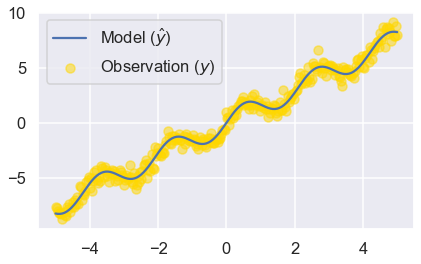

In [128]:
y_pred = sin_model(x, theta_est)

plt.plot(x, y_pred, label='Model ($\hat{y}$)')
plt.scatter(x, y, alpha=0.5, label='Observation ($y$)', color='gold')
plt.legend();

Run the following cell to see a plot of the loss values over each iteration of the following 3 variations of gradient descent: gradient descent with a static learning rate, gradient descent with a decaying learning rate, and stochastic gradient descent with a static learning rate.

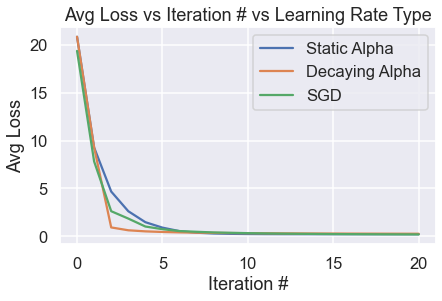

In [129]:
plt.plot(np.arange(len(loss)), loss, label='Static Alpha')
plt.plot(np.arange(len(loss)), loss_decay, label='Decaying Alpha')
plt.plot(np.arange(len(loss)), loss_stoch, label='SGD')
plt.xlabel('Iteration #')
plt.ylabel('Avg Loss')
plt.title('Avg Loss vs Iteration # vs Learning Rate Type')
plt.legend();

### Visualizing Loss
Let's visualize our loss functions and gain some insight as to how gradient descent optimizes our model parameters.

In the previous plot we saw the loss decrease with each iteration. In this part, we'll see the trajectory of the algorithm as it travels the loss surface? Run the following cells to see visualization of this trajectory. 

In [130]:
thetas = np.array(thetas).squeeze()
thetas_decay = np.array(thetas_decay).squeeze()
thetas_stoch = np.array(thetas_stoch).squeeze()
loss = np.array(loss)
loss_decay = np.array(loss_decay)
loss_stoch = np.array(loss_stoch)
thetas

array([[0.    , 0.    ],
       [2.6011, 2.6011],
       [0.9034, 2.591 ],
       [2.0563, 2.9631],
       [1.1589, 2.8669],
       [1.7939, 3.0728],
       [1.3216, 3.0015],
       [1.6495, 3.0291],
       [1.4233, 2.9882],
       [1.583 , 3.0103],
       [1.471 , 2.9893],
       [1.5504, 3.0017],
       [1.4944, 2.9914],
       [1.5342, 2.998 ],
       [1.506 , 2.9929],
       [1.526 , 2.9963],
       [1.5119, 2.9938],
       [1.5219, 2.9955],
       [1.5148, 2.9942],
       [1.5198, 2.9951],
       [1.5163, 2.9945]])

In [131]:
# Run me to see a 3D plot (gradient descent with static alpha)
plot_3d(thetas[:, 0], thetas[:, 1], loss, average_squared_loss, sin_model, x, y)

In [132]:
# Run me to see another 3D plot (gradient descent with decaying alpha)
plot_3d(thetas_decay[:, 0], thetas_decay[:, 1], loss_decay, average_squared_loss, sin_model, x, y)

In [133]:
# Run me to see another 3D plot (stochastic gradient descent)
plot_3d(thetas_stoch[:, 0], thetas_stoch[:, 1], loss_stoch, average_squared_loss, sin_model, x, y)

Another common way of visualizing 3D dynamics is with a _contour_ plot. Run the following cells.

In [134]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [135]:
def contour_plot(title, theta_history, loss_function, model, x, y):
    """
    The function takes the following as argument:
        theta_history: a (N, 2) array of theta history
        loss: a list or array of loss value
        loss_function: for example, l2_loss
        model: for example, sin_model
        x: the original x input
        y: the original y output
    """
    theta_1_series = theta_history[:,0] # a list or array of theta_1 value
    theta_2_series = theta_history[:,1] # a list or array of theta_2 value

    ## In the following block of code, we generate the z value
    ## across a 2D grid
    theta1_s = np.linspace(np.min(theta_1_series) - 0.1, np.max(theta_1_series) + 0.1)
    theta2_s = np.linspace(np.min(theta_2_series) - 0.1, np.max(theta_2_series) + 0.1)

    x_s, y_s = np.meshgrid(theta1_s, theta2_s)
    data = np.stack([x_s.flatten(), y_s.flatten()]).T
    ls = []
    for theta1, theta2 in data:
        l = loss_function(model(x, np.array([theta1, theta2])), y)
        ls.append(l)
    z = np.array(ls).reshape(50, 50)
    
    # Create trace of theta point
    # Create the contour 
    theta_points = go.Scatter(name="theta Values", 
                              x=theta_1_series, 
                              y=theta_2_series,
                              mode="lines+markers")
    lr_loss_contours = go.Contour(x=theta1_s, 
                                  y=theta2_s, 
                                  z=z, 
                                  colorscale='Viridis', reversescale=True)

    plotly.offline.iplot(go.Figure(data=[lr_loss_contours, theta_points], layout={'title': title}))

In [136]:
contour_plot('Gradient Descent with Static Learning Rate', thetas, average_squared_loss, sin_model, x, y)

In [137]:
contour_plot('Gradient Descent with Decay Learning Rate', thetas_decay, average_squared_loss, sin_model, x, y)

In [138]:
contour_plot('Stochastic Gradient Descent', thetas_stoch, average_squared_loss, sin_model, x, y)

<!-- BEGIN QUESTION -->

#### Question 8d: Analyzing Learning Rates

In 1-2 sentences, describe what you notice about the path that $\theta$ takes with a static learning rate vs. a decaying learning rate and for batch vs. stochastic gradient descent. Based on these comparisons, why do we often prefer SGD over batch GD in practice? In your answer, refer to the plots above.

<!--
BEGIN QUESTION
name: q8d
manual: true
points: 2
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



---

**Congrats, you've finished Homework 8!**

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()